# Feature Engineering from Just Latitude and Longitude

The purpose of this notebook is to demonstrate a few feature engineering techniques that use only latitude and longitude.

It compares these feature engineering techniques by using them on a prediction problem from Kaggle, "Predicting Airbnb Prices" ([dataset](https://www.kaggle.com/datasets/kritikseth/us-airbnb-open-data)).

Tools used include `polars`, `numpy`, `matplotlib`, `xgboost`, `scikit-learn`, and `scipy`.

## 0. Env

In [1]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import geohash2
from scipy import spatial

In [2]:
TRAIN_TEST_SPLIT_FRACTION = 0.8
MODEL_TARGET = "price_log1p"
GEOHASH_PRECISION = 6

## 1. Load Data

#### Choosing a target city for the problem... which city has the most data?

In [3]:
(
    pl.read_csv("../data/AB_US_2023.csv")
    ["city"]
    .value_counts()
    .sort(by="counts", descending=True)
    .head(5)
)

city,counts
str,u32
"""New York City""",42931
"""Los Angeles""",42451
"""Broward County…",16899
"""Austin""",14368
"""Clark County""",13933


#### Load data for New York City

In [4]:
df_query = (
    pl.scan_csv("../data/AB_US_2023.csv")
    .filter(pl.col("city") == "New York City")
    .select(pl.col(["latitude", "longitude", "price"]))
    .with_columns(pl.col("price").log1p().suffix("_log1p"))
)

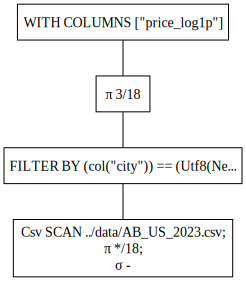

In [5]:
df_query.show_graph(optimized=False)

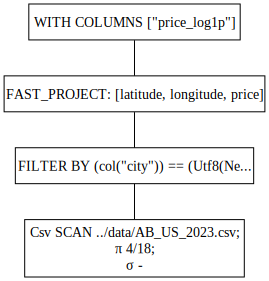

In [6]:
df_query.show_graph(optimized=True)

In [7]:
df = df_query.collect()

In [8]:
df = (
    df
    .with_row_count(name="row_number")
    .with_columns([
        (pl.col("row_number") < TRAIN_TEST_SPLIT_FRACTION * len(df)).alias("is_train")
    ])
)

#### Viewing the data

In [9]:
display(
    df
    .head()
)

row_number,latitude,longitude,price,price_log1p,is_train
u32,f64,f64,i64,f64,bool
0,40.75356,-73.98559,150,5.01728,true
1,40.68535,-73.95512,60,4.110874,true
2,40.8038,-73.96751,75,4.330733,true
3,40.76457,-73.98317,68,4.234107,true
4,40.66265,-73.99454,275,5.620401,true


## 2. Brief EDA

#### Distribution of Prices

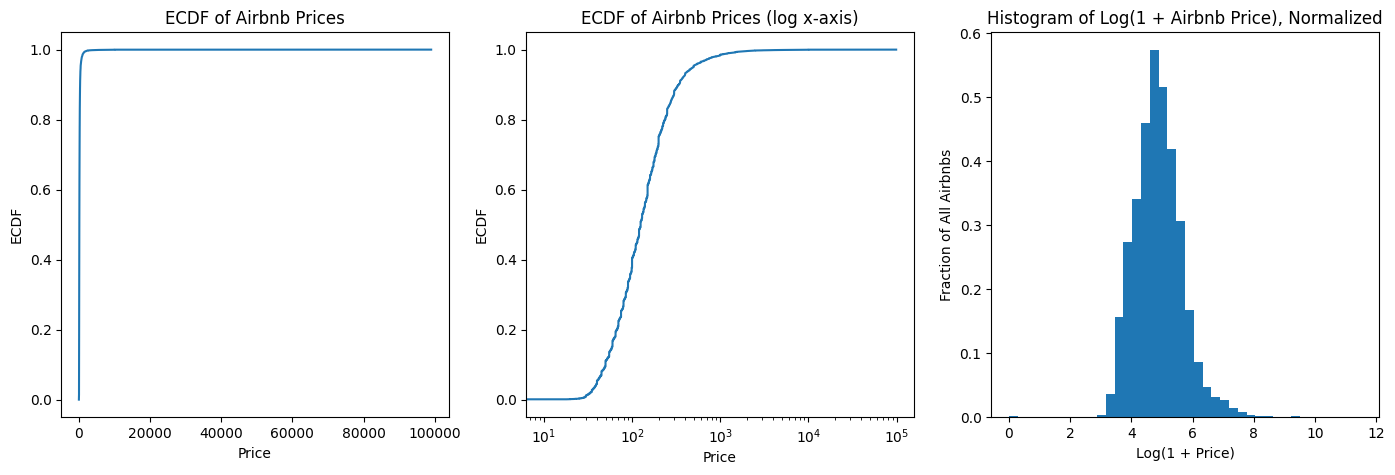

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

ax1.plot(df["price"].sort(), np.linspace(0, 1, len(df)))
ax1.set_xlabel("Price")
ax1.set_ylabel("ECDF")
ax1.set_title("ECDF of Airbnb Prices")

ax2.plot(df["price"].sort(), np.linspace(0, 1, len(df)))
ax2.set_xscale("log")
ax2.set_xlabel("Price")
ax2.set_ylabel("ECDF")
ax2.set_title("ECDF of Airbnb Prices (log x-axis)")

ax3.hist(df["price_log1p"], bins=40, density=True)
ax3.set_xlabel("Log(1 + Price)")
ax3.set_ylabel("Fraction of All Airbnbs")
ax3.set_title("Histogram of Log(1 + Airbnb Price), Normalized")

plt.savefig("../../static/images/distribution-of-airbnb-price.png")

#### Distribution over Space

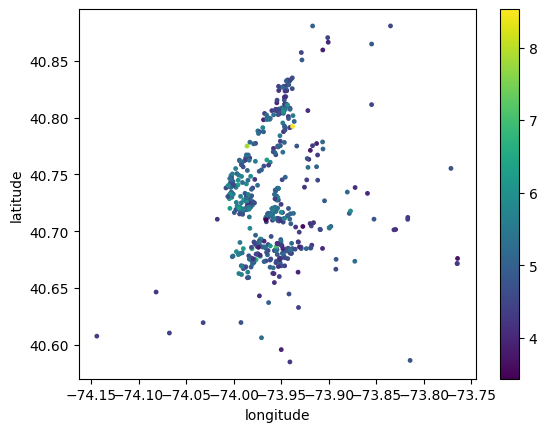

In [11]:
sample_size = 500
df_sample = df.head(sample_size)
plt.scatter(
    df_sample["longitude"],
    df_sample["latitude"],
    c=df_sample["price_log1p"],
    s=6,
    cmap="viridis"
)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.colorbar()
plt.show()

In [12]:
df.select(["latitude", "longitude", "price"]).corr()

latitude,longitude,price
f64,f64,f64
1.0,0.046993,0.008133
0.046993,1.0,-0.058381
0.008133,-0.058381,1.0


### 1.1 Raw Latitude and Longitude

In [13]:
MODEL_FEATURE_LIST_NAME = "raw_lat_lon"
MODEL_FEATURE_LIST = ["latitude", "longitude"]

X_train = df.filter(pl.col("is_train")).select(MODEL_FEATURE_LIST)
y_train = df.filter(pl.col("is_train")).select(MODEL_TARGET)
X_test = df.filter(~pl.col("is_train")).select(MODEL_FEATURE_LIST)
y_test = df.filter(~pl.col("is_train")).select(MODEL_TARGET).to_numpy()

model_performance_list = []
for model_name, model_class in zip(
    ["xgboost", "ridge regression"],
    [XGBRegressor, Ridge]
):
    model = model_class().fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    model_performance = mean_squared_error(y_test, y_predicted)
    model_performance_list.append({
        "feature_list_name": MODEL_FEATURE_LIST_NAME,
        "model_name": model_name,
        "model_performance": model_performance
    })

raw_lat_lon_results_df = (
    pd.DataFrame
    .from_records(model_performance_list)
    .pivot_table(
        index="feature_list_name",
        columns="model_name",
        values="model_performance",
        aggfunc="first"
    )
)

display(
    raw_lat_lon_results_df
    .style
    .format("{:.3f}")
    .background_gradient(vmin=0, vmax=1)
    .to_html()
)

'<style type="text/css">\n#T_64e5c_row0_col0 {\n  background-color: #0f76b3;\n  color: #f1f1f1;\n}\n#T_64e5c_row0_col1 {\n  background-color: #589ec8;\n  color: #f1f1f1;\n}\n</style>\n<table id="T_64e5c">\n  <thead>\n    <tr>\n      <th class="index_name level0" >model_name</th>\n      <th id="T_64e5c_level0_col0" class="col_heading level0 col0" >ridge regression</th>\n      <th id="T_64e5c_level0_col1" class="col_heading level0 col1" >xgboost</th>\n    </tr>\n    <tr>\n      <th class="index_name level0" >feature_list_name</th>\n      <th class="blank col0" >&nbsp;</th>\n      <th class="blank col1" >&nbsp;</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th id="T_64e5c_level0_row0" class="row_heading level0 row0" >raw_lat_lon</th>\n      <td id="T_64e5c_row0_col0" class="data row0 col0" >0.724</td>\n      <td id="T_64e5c_row0_col1" class="data row0 col1" >0.558</td>\n    </tr>\n  </tbody>\n</table>\n'

### 1.2 Neighborhood Density

In [14]:
def add_density_feature_columns_to_dataframe(geo_df: pl.DataFrame) -> pl.DataFrame:
    tree = spatial.cKDTree(df.select(["latitude", "longitude"]))
    result = geo_df.with_columns(
        pl.Series(
            "spatial_density",
            tree.query_ball_point(geo_df.select(["latitude", "longitude"]), .02, return_length=True)
        )
    )
    return result

In [15]:
df_w_density = add_density_feature_columns_to_dataframe(df)

MODEL_FEATURE_LIST_NAME = "spatial_density"
MODEL_FEATURE_LIST = ["spatial_density"]

X_train = df_w_density.filter(pl.col("is_train")).select(MODEL_FEATURE_LIST)
y_train = df_w_density.filter(pl.col("is_train")).select(MODEL_TARGET)
X_test = df_w_density.filter(~pl.col("is_train")).select(MODEL_FEATURE_LIST)
y_test = df_w_density.filter(~pl.col("is_train")).select(MODEL_TARGET).to_numpy()

model_performance_list = []
for model_name, model_class in zip(
    ["xgboost", "ridge regression"],
    [XGBRegressor, Ridge]
):
    model = model_class().fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    model_performance = mean_squared_error(y_test, y_predicted)
    model_performance_list.append({
        "feature_list_name": MODEL_FEATURE_LIST_NAME,
        "model_name": model_name,
        "model_performance": model_performance
    })

spatial_density_results_df = (
    pd.DataFrame
    .from_records(model_performance_list)
    .pivot_table(
        index="feature_list_name",
        columns="model_name",
        values="model_performance",
        aggfunc="first"
    )
)

display(
    pd.concat([raw_lat_lon_results_df, spatial_density_results_df])
    .style
    .format("{:.3f}")
    .background_gradient(vmin=0, vmax=1)
    .to_html()
)

'<style type="text/css">\n#T_4fb01_row0_col0 {\n  background-color: #0f76b3;\n  color: #f1f1f1;\n}\n#T_4fb01_row0_col1 {\n  background-color: #589ec8;\n  color: #f1f1f1;\n}\n#T_4fb01_row1_col0 {\n  background-color: #1c7fb8;\n  color: #f1f1f1;\n}\n#T_4fb01_row1_col1 {\n  background-color: #2081b9;\n  color: #f1f1f1;\n}\n</style>\n<table id="T_4fb01">\n  <thead>\n    <tr>\n      <th class="index_name level0" >model_name</th>\n      <th id="T_4fb01_level0_col0" class="col_heading level0 col0" >ridge regression</th>\n      <th id="T_4fb01_level0_col1" class="col_heading level0 col1" >xgboost</th>\n    </tr>\n    <tr>\n      <th class="index_name level0" >feature_list_name</th>\n      <th class="blank col0" >&nbsp;</th>\n      <th class="blank col1" >&nbsp;</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th id="T_4fb01_level0_row0" class="row_heading level0 row0" >raw_lat_lon</th>\n      <td id="T_4fb01_row0_col0" class="data row0 col0" >0.724</td>\n      <td id="T_4fb01_row0_col1

### 1.3 Geohash category

In [16]:
def add_geohash_category_column_to_dataframe(geo_df: pl.DataFrame, geohash_precision=6) -> pl.DataFrame:
    geo_df = (
        geo_df
        .with_columns(
            geo_df
            .select(["latitude", "longitude"])
            .apply(
                lambda x: geohash2.encode(x[0], x[1], precision=geohash_precision)
            )
            .rename({"apply": "geohash"})
        )
    )
    return geo_df

In [17]:
def add_geohash_one_hot_encoded_category_columns_to_dataframe(
    geo_df: pl.DataFrame,
    geohash_precision=6
) -> pl.DataFrame:
    result = (
        add_geohash_category_column_to_dataframe(
            geo_df,
            geohash_precision=geohash_precision
        )
        .to_dummies(columns="geohash")
    )
    return result

In [25]:
df_w_geohash_ohe = add_geohash_one_hot_encoded_category_columns_to_dataframe(df)
display(df_w_geohash_ohe.head())
display(df_w_geohash_ohe.filter(pl.col("is_train")).head())

MODEL_FEATURE_PATTERN = "^geohash_.*$"

X_train = df_w_geohash_ohe.filter(pl.col("is_train")).select(pl.col(MODEL_FEATURE_PATTERN))
y_train = df_w_geohash_ohe.filter(pl.col("is_train")).select(MODEL_TARGET)
X_test = df_w_geohash_ohe.filter(~pl.col("is_train")).select(pl.col(MODEL_FEATURE_PATTERN))
y_test = df_w_geohash_ohe.filter(~pl.col("is_train")).select(MODEL_TARGET).to_numpy()

for model_name, model_class in zip(
    ["xgboost", "ridge regression"],
    [XGBRegressor, Ridge]
):
    model = model_class().fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    print(f"{model_name}, {mean_squared_error(y_test, y_predicted):.7f} (sklearn)")

geohash_categorical_results_df = (
    pd.DataFrame
    .from_records(model_performance_list)
    .pivot_table(
        index="feature_list_name",
        columns="model_name",
        values="model_performance",
        aggfunc="first"
    )
)

display(
    pd.concat([
        raw_lat_lon_results_df,
        spatial_density_results_df,
        geohash_categorical_results_df
    ])
    .style
    .format("{:.3f}")
    .background_gradient(vmin=0, vmax=1)
    .to_html()
)

row_number,latitude,longitude,price,price_log1p,is_train,geohash_dr5nqm,geohash_dr5nqq,geohash_dr5nqs,geohash_dr5nqw,geohash_dr5nx1,geohash_dr5nx2,geohash_dr5nx3,geohash_dr5nx7,geohash_dr5nxd,geohash_dr5nxm,geohash_dr5nxq,geohash_dr5nxt,geohash_dr5nxv,geohash_dr5nxw,geohash_dr5nzb,geohash_dr5nzv,geohash_dr5nzy,geohash_dr5q85,geohash_dr5q8e,geohash_dr5q8g,geohash_dr5q8j,geohash_dr5q8k,geohash_dr5q8m,geohash_dr5q8r,geohash_dr5q8s,geohash_dr5q8t,geohash_dr5q8u,geohash_dr5q8v,geohash_dr5q8z,geohash_dr5q9p,geohash_dr5q9r,…,geohash_dr72xf,geohash_dr72xg,geohash_dr72xj,geohash_dr72xk,geohash_dr72xm,geohash_dr72xq,geohash_dr72xs,geohash_dr72xt,geohash_dr72xu,geohash_dr72xw,geohash_dr7800,geohash_dr7802,geohash_dr7805,geohash_dr7808,geohash_dr780j,geohash_dr780n,geohash_dr780p,geohash_dr780q,geohash_dr780r,geohash_dr780t,geohash_dr7810,geohash_dr7811,geohash_dr7820,geohash_dr7821,geohash_dr7822,geohash_dr7823,geohash_dr7824,geohash_dr7825,geohash_dr7827,geohash_dr782g,geohash_dr782p,geohash_dr782u,geohash_dr782v,geohash_dr7834,geohash_dr7880,geohash_dr7885,geohash_dr7887
u32,f64,f64,i64,f64,bool,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
0,40.75356,-73.98559,150,5.01728,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40.68535,-73.95512,60,4.110874,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,40.8038,-73.96751,75,4.330733,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,40.76457,-73.98317,68,4.234107,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,40.66265,-73.99454,275,5.620401,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


row_number,latitude,longitude,price,price_log1p,is_train,geohash_dr5nqm,geohash_dr5nqq,geohash_dr5nqs,geohash_dr5nqw,geohash_dr5nx1,geohash_dr5nx2,geohash_dr5nx3,geohash_dr5nx7,geohash_dr5nxd,geohash_dr5nxm,geohash_dr5nxq,geohash_dr5nxt,geohash_dr5nxv,geohash_dr5nxw,geohash_dr5nzb,geohash_dr5nzv,geohash_dr5nzy,geohash_dr5q85,geohash_dr5q8e,geohash_dr5q8g,geohash_dr5q8j,geohash_dr5q8k,geohash_dr5q8m,geohash_dr5q8r,geohash_dr5q8s,geohash_dr5q8t,geohash_dr5q8u,geohash_dr5q8v,geohash_dr5q8z,geohash_dr5q9p,geohash_dr5q9r,…,geohash_dr72xf,geohash_dr72xg,geohash_dr72xj,geohash_dr72xk,geohash_dr72xm,geohash_dr72xq,geohash_dr72xs,geohash_dr72xt,geohash_dr72xu,geohash_dr72xw,geohash_dr7800,geohash_dr7802,geohash_dr7805,geohash_dr7808,geohash_dr780j,geohash_dr780n,geohash_dr780p,geohash_dr780q,geohash_dr780r,geohash_dr780t,geohash_dr7810,geohash_dr7811,geohash_dr7820,geohash_dr7821,geohash_dr7822,geohash_dr7823,geohash_dr7824,geohash_dr7825,geohash_dr7827,geohash_dr782g,geohash_dr782p,geohash_dr782u,geohash_dr782v,geohash_dr7834,geohash_dr7880,geohash_dr7885,geohash_dr7887
u32,f64,f64,i64,f64,bool,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
0,40.75356,-73.98559,150,5.01728,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40.68535,-73.95512,60,4.110874,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,40.8038,-73.96751,75,4.330733,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,40.76457,-73.98317,68,4.234107,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,40.66265,-73.99454,275,5.620401,true,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


xgboost, 0.5920653 (sklearn)
ridge regression, 0.5640281 (sklearn)


KeyError: '`Styler.apply` and `.applymap` are not compatible with non-unique index or columns.'

### 1.4 Geohash Target Encoding

In [ ]:
df = (
    df
    .join(
        df
        .filter(pl.col("is_train"))
        .groupby(f"geohash_{geohash_precision}")
        .agg([
            pl.col("price").median().alias("geohash_price_median"),
            pl.col("price").max().alias("geohash_price_max"),
        ]),
        on=f"geohash_{geohash_precision}",
        how="left"
    )
    .join(
        df
        # .filter(pl.col("is_train"))
        .groupby(f"geohash_{geohash_precision}")
        .agg([
            pl.col("price").count().alias("geohash_price_count"),
        ]),
        on=f"geohash_{geohash_precision}",
        how="left"
    )
)

In [ ]:
MODEL_FEATURE_LIST = [
    "geohash_price_count",
    "geohash_price_median",
    "geohash_price_max",
]

X_train = df.filter(pl.col("is_train") & pl.col("geohash_price_max").is_not_null()).select(MODEL_FEATURE_LIST)
y_train = df.filter(pl.col("is_train") & pl.col("geohash_price_max").is_not_null()).select(MODEL_TARGET)
X_test = df.filter(~pl.col("is_train") & pl.col("geohash_price_max").is_not_null()).select(MODEL_FEATURE_LIST)
y_test = df.filter(~pl.col("is_train") & pl.col("geohash_price_max").is_not_null()).select(MODEL_TARGET).to_numpy()

for model_name, model_class in zip(
    ["xgboost", "linear regression", "ridge regression"],
    [XGBRegressor, LinearRegression, Ridge]
):
    model = model_class().fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    print(f"{model_name}, {mean_squared_error(y_test, y_predicted):.7f} (sklearn)")